In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms

In [4]:
mean_gray = 0.1307
stddev_gray = 0.3071

transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray,), (stddev_gray,))])

In [5]:
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


102.8%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




100.0%
112.7%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
img = mnist_train[12][0].numpy() * stddev_gray + mean_gray

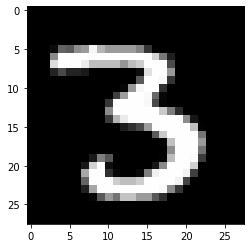

In [7]:
plt.imshow(img.reshape(28, 28), cmap='gray')

In [9]:
label = mnist_train[12][1]
label

3

In [10]:
batch_size=1024

In [11]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

In [12]:
class MNISTnet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.5)
        self.maxpool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()

        self.fc1 = nn.Linear(3000, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)

        # switches to vector representation
        x = x.view(-1, 3000)

        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)

        x = self.fc2(x)

        return x


In [14]:
net = MNISTnet()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [15]:
num_epochs = 100

In [18]:
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):

    iter_loss = 0.0
    correct = 0
    iterations = 0

    net.train()

    for i, (items, classes) in enumerate(mnist_train_loader):

        items = Variable(items)
        classes = Variable(classes)

        optimizer.zero_grad() # clears off gradients from past
        outputs = net(items) # forward pass
        loss = criterion(outputs, classes) # calculates loss
        iter_loss += loss.data # accumulate the loss
        loss.backward() # calculate the gradients with help of back propagation
        optimizer.step()

        # record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    # record loss
    train_loss.append(iter_loss/iterations)

    # record accuracy
    train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))

    # validate

    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()

    for i, (items, classes) in enumerate(mnist_valid_loader):

        items = Variable(items)
        classes = Variable(classes)

        outputs = net(items) # forward pass
        loss += criterion(outputs, classes).data

        # record correct predictions
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()

        iterations += 1


    valid_loss.append(loss/iterations)
    valid_accuracy.append(correct / len(mnist_valid_loader.dataset) * 100.0)

    print(f"Epoch: {epoch+1}/{num_epochs}, Tr Loss: {train_loss[-1]}, Tr Acc: {train_accuracy[-1]}, Test Loss: {valid_loss[-1]}, Test Acc: {valid_accuracy[-1]}")

Epoch: 1/100, Tr Loss: 0.4618062376976013, Tr Acc: 86.23833465576172, Test Loss: 0.25151944160461426, Test Acc: 92.54000091552734
Epoch: 2/100, Tr Loss: 0.27242809534072876, Tr Acc: 91.95999908447266, Test Loss: 0.1702285259962082, Test Acc: 94.91999816894531
Epoch: 3/100, Tr Loss: 0.20042388141155243, Tr Acc: 94.10166931152344, Test Loss: 0.13057541847229004, Test Acc: 95.91000366210938
Epoch: 4/100, Tr Loss: 0.16566574573516846, Tr Acc: 95.163330078125, Test Loss: 0.10905113071203232, Test Acc: 96.63999938964844
Epoch: 5/100, Tr Loss: 0.14109380543231964, Tr Acc: 95.86000061035156, Test Loss: 0.09534826129674911, Test Acc: 97.12999725341797
Epoch: 6/100, Tr Loss: 0.1274431198835373, Tr Acc: 96.15499877929688, Test Loss: 0.08194892108440399, Test Acc: 97.45999908447266
Epoch: 7/100, Tr Loss: 0.11485692858695984, Tr Acc: 96.66500091552734, Test Loss: 0.07599520683288574, Test Acc: 97.7699966430664
Epoch: 8/100, Tr Loss: 0.10558293759822845, Tr Acc: 96.836669921875, Test Loss: 0.0669346

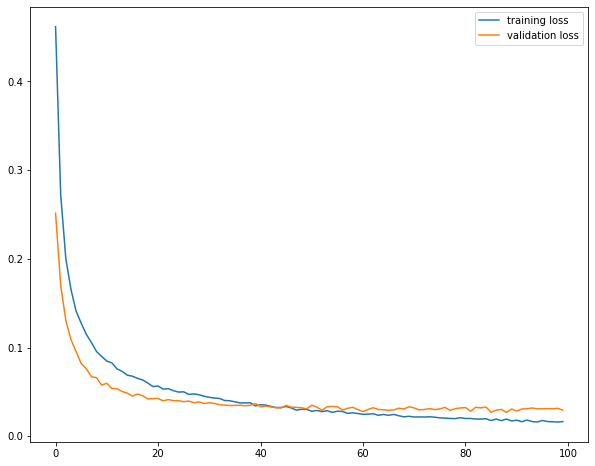

In [19]:
# loss
f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

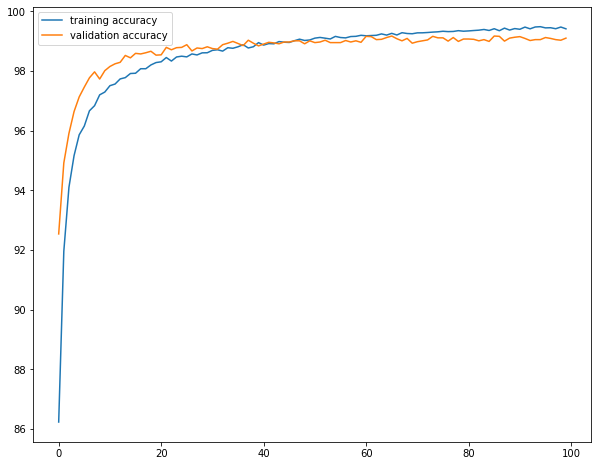

In [20]:
# accuracy

f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()